# BBC News Classification - Mini Project

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import permutations

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

## Data loading

In [2]:
df_train = pd.read_csv('data/BBC News Train.csv')
df_test = pd.read_csv('data/BBC News Test.csv')

In [3]:
# category = {'business':0, 'tech':1, 'politics':2, 'sport':3, 'entertainment':4 }

In [4]:
df_train['category_num'] = df_train['Category'].factorize()[0]

In [5]:
df_train.head()

,ArticleId,Text,Category,category_num
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


## EDA

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ArticleId     1490 non-null   int64 
 1   Text          1490 non-null   object
 2   Category      1490 non-null   object
 3   category_num  1490 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.7+ KB


In [7]:
df_train.sample(5)

,ArticleId,Text,Category,category_num
362,429,china suspends 26 power projects china has ord...,business,0
927,204,how to make a gigapixel picture the largest di...,tech,1
1385,363,japanese growth grinds to a halt growth in jap...,business,0
1264,225,eu-us seeking deal on air dispute the eu and u...,business,0
13,812,bp surges ahead on high oil price oil giant bp...,business,0


In [8]:
print(f'Duplicated text cols in our training data: {df_train['Text'].duplicated().sum()}')

Duplicated text cols in our training data: 50


In [9]:
# example of a duplicated article
df_train[df_train['Text'].str.contains("prince crowned")]

,ArticleId,Text,Category,category_num
62,476,prince crowned top music earner prince earne...,entertainment,4
157,853,prince crowned top music earner prince earne...,entertainment,4


In [10]:
df_train.drop_duplicates(subset = 'Text', inplace = True)

In [11]:
print(f'Now we are left with {len(df_train)} rows!')

Now we are left with 1440 rows!


In [12]:
df_train['Category'].value_counts()

Category
sport            342
business         335
politics         266
entertainment    263
tech             234
Name: count, dtype: int64

In [13]:
df_train['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

## 

In [14]:
y = df_train['category_num'].tolist()

## Visualizations

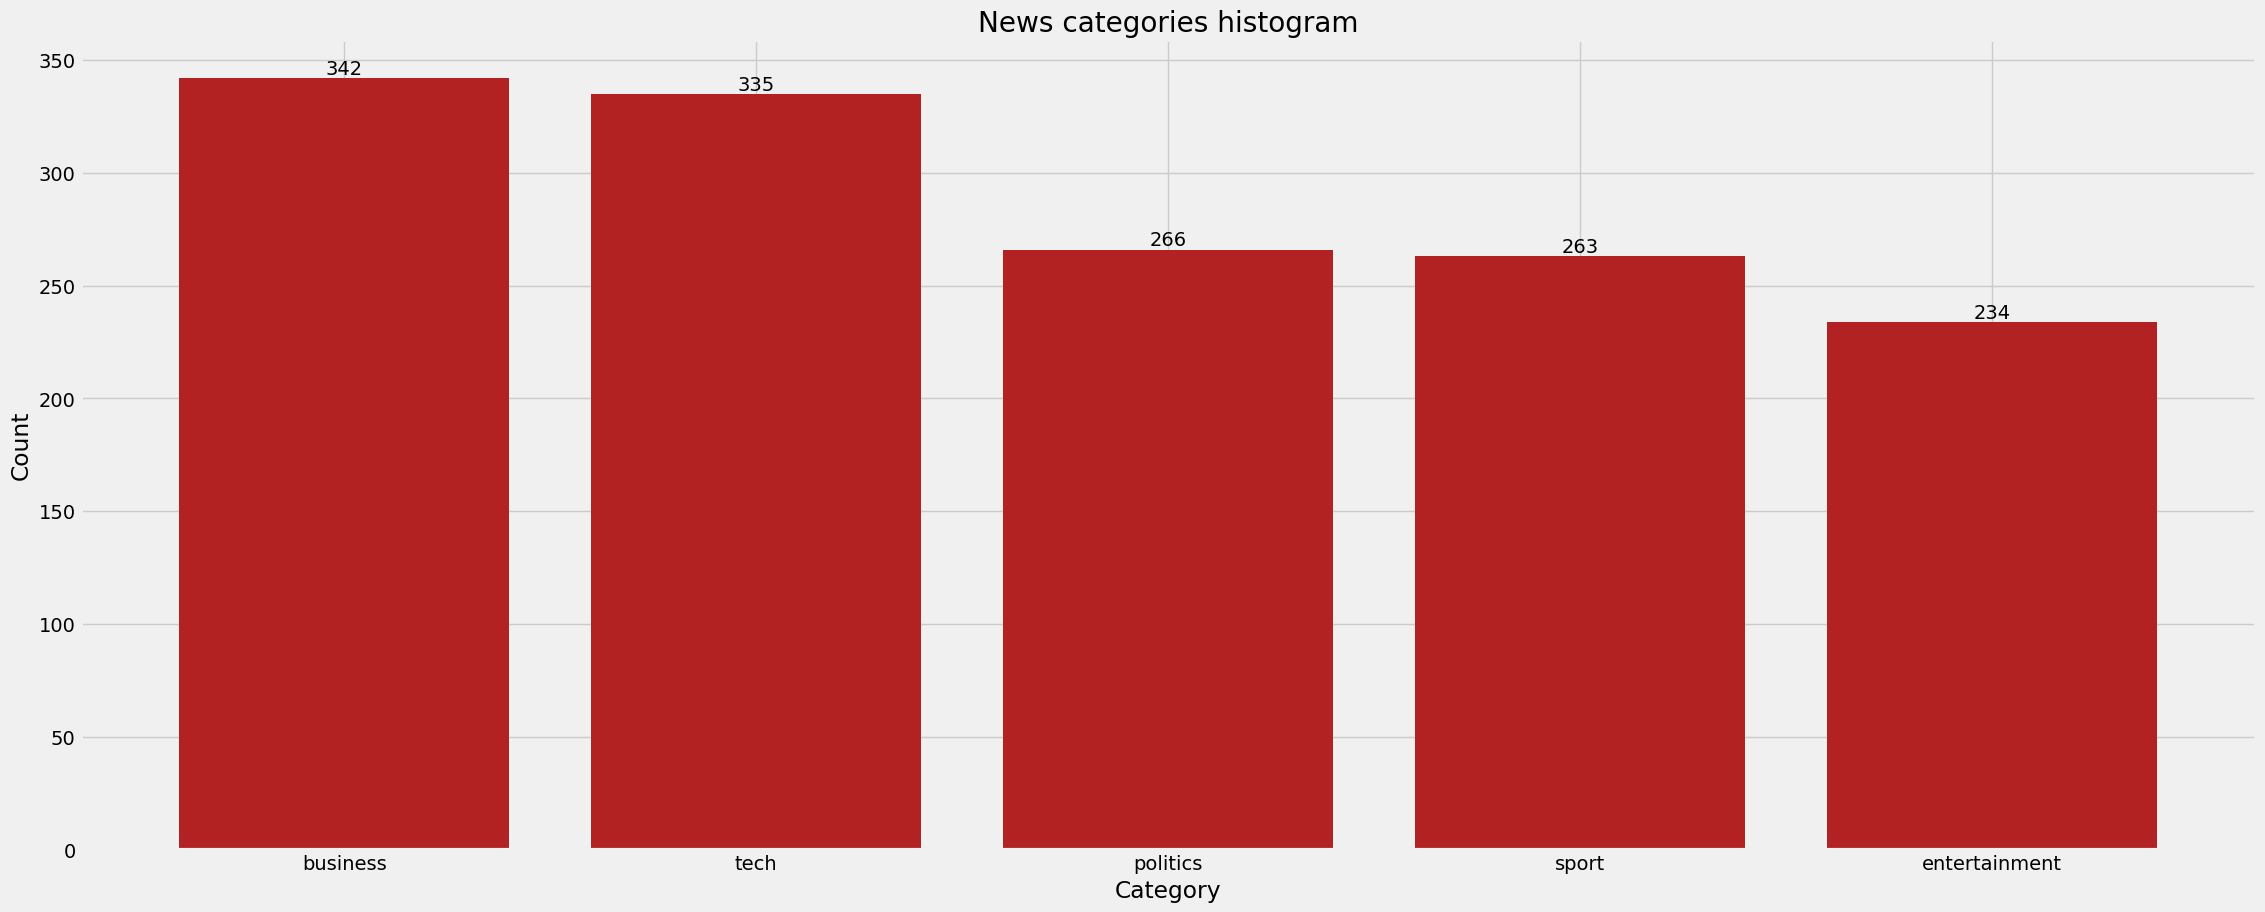

In [15]:
plt.style.use('fivethirtyeight')
fix, ax = plt.subplots(figsize = (25, 10))

cat = df_train['Category'].value_counts()
ind = df_train['Category'].unique()

plt.bar(ind, cat, color = 'firebrick', align = 'center')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height(),
            '{:.0f}'.format(p.get_height()),
            ha='center',
            va='bottom'
           )

plt.title('News categories histogram')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [16]:
stats = df_train[['Text', 'Category']]
stats['word_count'] = df_train.Text.apply(lambda x: len(x.split()))
stats[['Category', 'word_count']].groupby('Category').describe()

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_13360/435826075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats['word_count'] = df_train.Text.apply(lambda x: len(x.split()))


word_count                                                \
                   count        mean         std    min     25%    50%   
Category                                                                 
business           335.0  334.274627  133.713125  145.0  253.00  304.0   
entertainment      263.0  335.444867  207.134549  144.0  229.00  271.0   
politics           266.0  451.642857  261.490785   90.0  320.25  445.0   
sport              342.0  336.877193  185.930006  116.0  211.50  296.5   
tech               234.0  509.222222  212.922747  188.0  345.25  461.5   

                               
                  75%     max  
Category                       
business       391.50   902.0  
entertainment  380.00  2448.0  
politics       527.75  3345.0  
sport          416.75  1671.0  
tech           633.75  1549.0

In [17]:
stats['word_count']

0       301
1       325
2       514
3       634
4       355
       ... 
1485    223
1486    558
1487    237
1488    560
1489    295
Name: word_count, Length: 1440, dtype: int64

Text(0.5, 1.0, 'Number of words by category histogram')

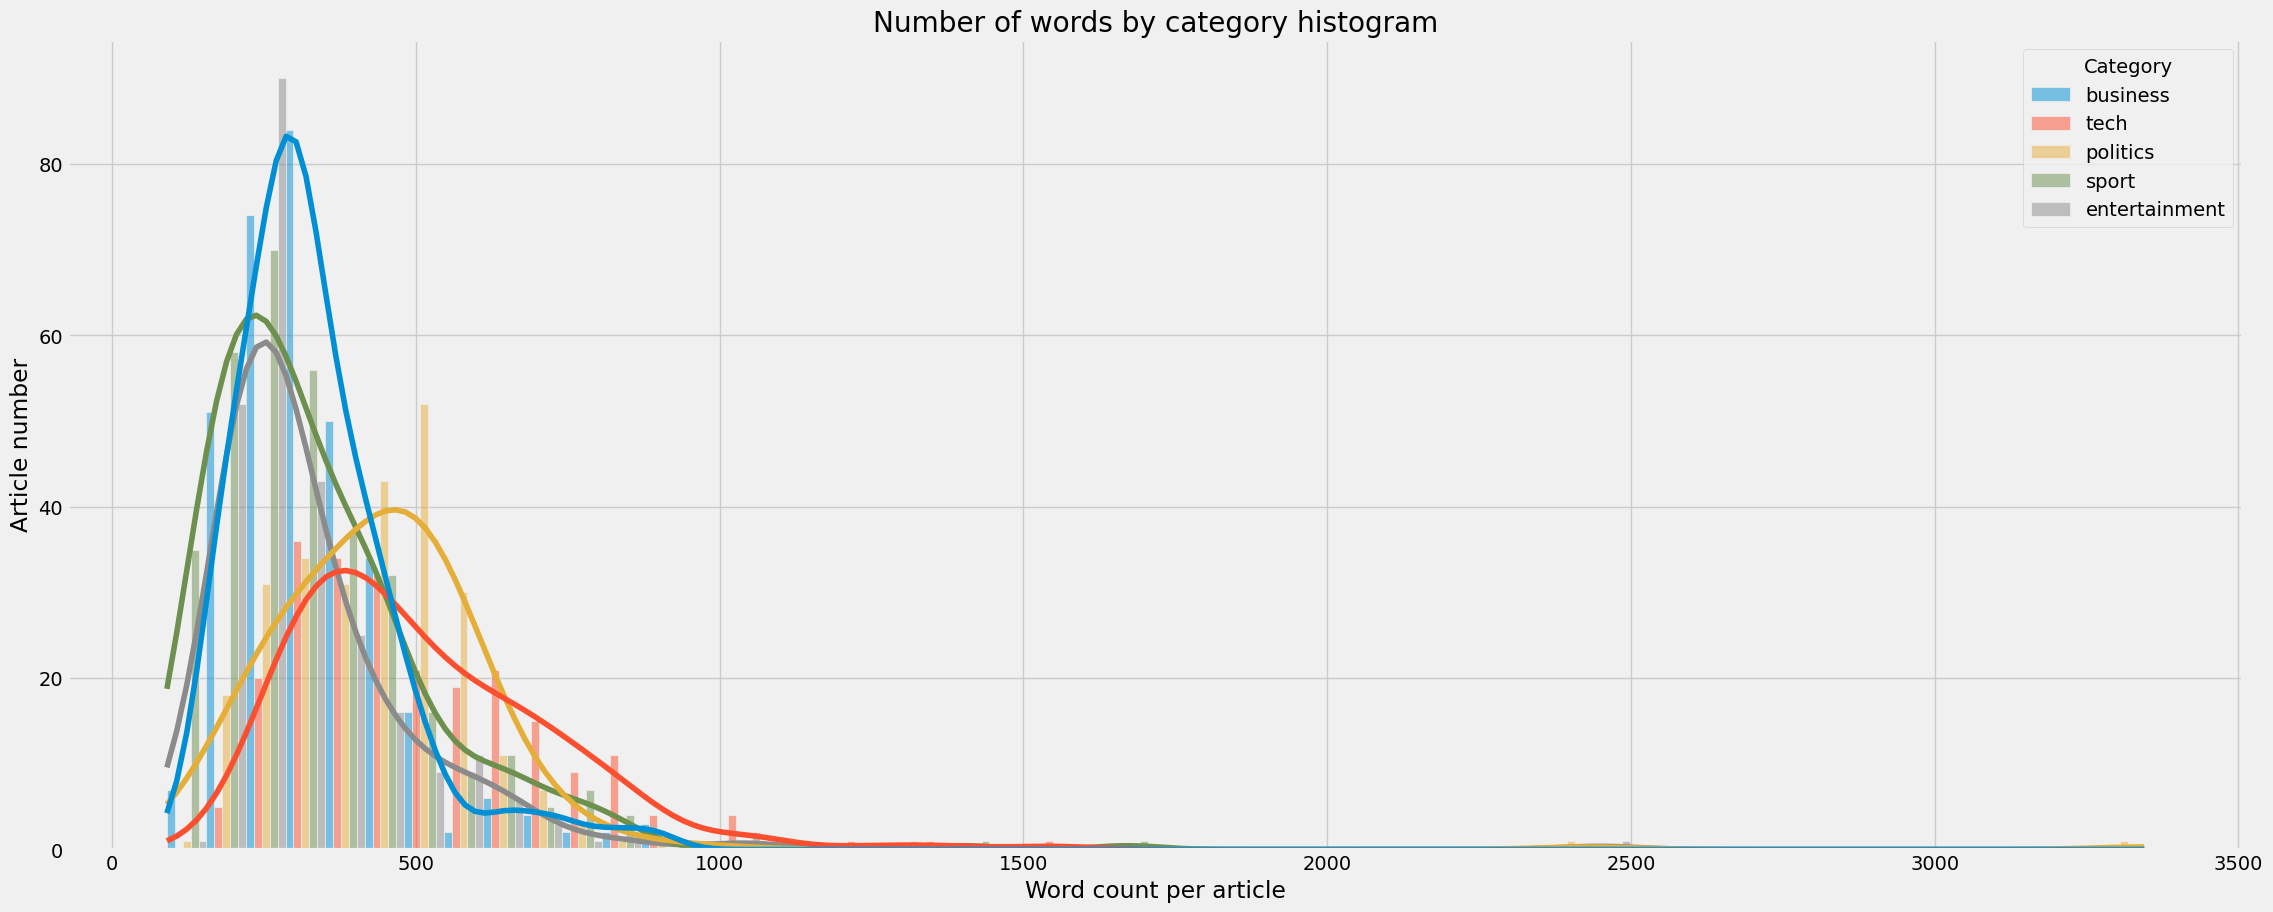

In [18]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

sns.histplot(data=stats, x='word_count', hue='Category', multiple='dodge', legend='Category', kde = True, bins = 50)

plt.xlabel('Word count per article')
plt.ylabel('Article number')
plt.title('Number of words by category histogram')

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_13360/1099105005.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels = stats['Category'].unique(), patch_artist=True)


Text(0, 0.5, 'Word count')

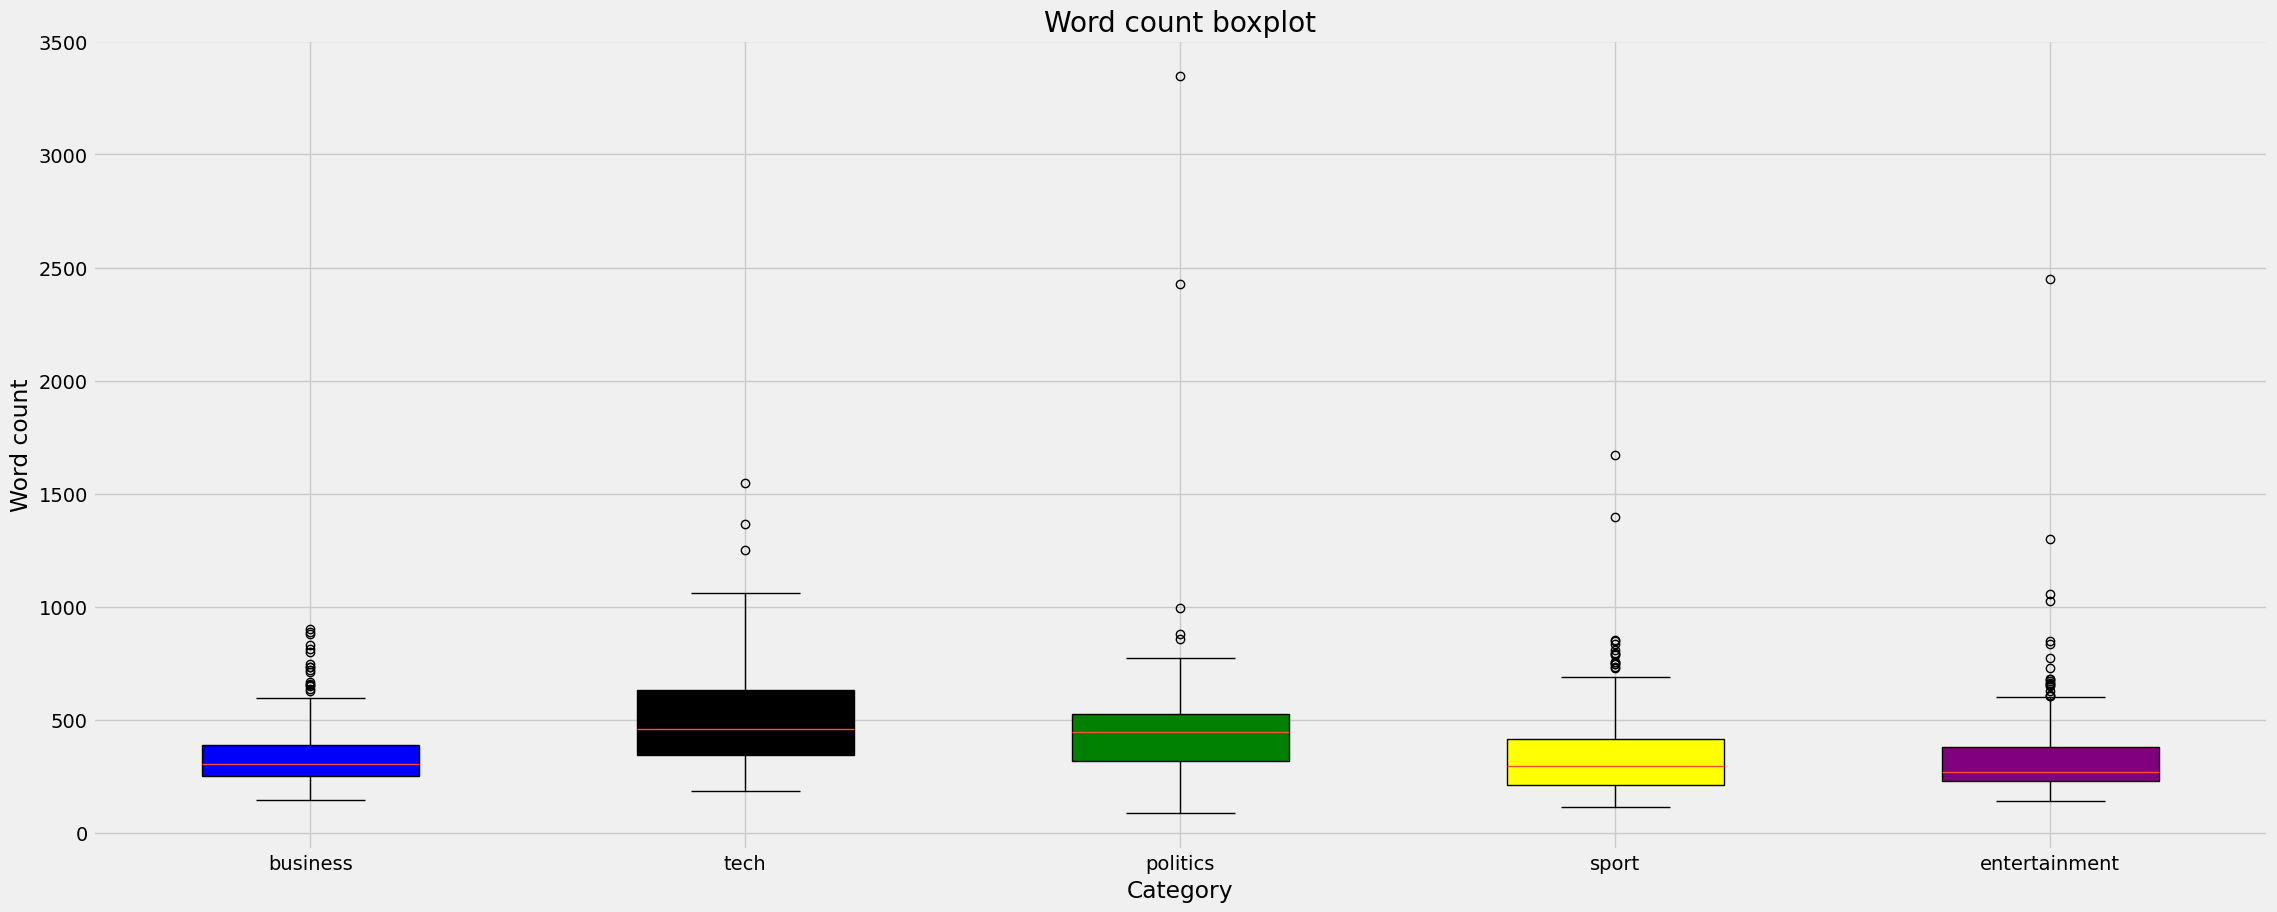

In [19]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

wc_group = stats.groupby('Category')['word_count'].apply(list)
data = [wc_group[cat] for cat in stats['Category'].unique()]

bp = plt.boxplot(data, labels = stats['Category'].unique(), patch_artist=True)

colors = ['blue', 'black', 'green', 'yellow', 'purple']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Word count boxplot')
plt.xlabel('Category')
plt.ylabel('Word count')

In [20]:
df_train_text = df_train['Text']

## Term frequency - Inverse Document Frequency (TF-IDF)

In [21]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df_train_text)

df_tfidf = pd.DataFrame(features.toarray(), columns=tfidf.get_feature_names_out())


In [22]:
df_tfidf.shape

(1440, 250233)

In [23]:
df_tfidf_eight = df_tfidf.iloc[7]
sorted_doc_eight_scores = df_tfidf_eight.sort_values(ascending=False)

In [24]:
sorted_doc_eight_scores.index

Index(['vabres', 'sir alan', 'parker', 'film', 'mr vabres', 'vabres said',
       'alan', 'director', 'sir', 'british film',
       ...
       'family tradition', 'family understand', 'family variety', 'family ve',
       'family village', 'family viruses', 'family wife', 'family worms',
       'famine', 'zvonareva wimbledon'],
      dtype='object', length=250233)

Text(0.5, 0, 'Terms')

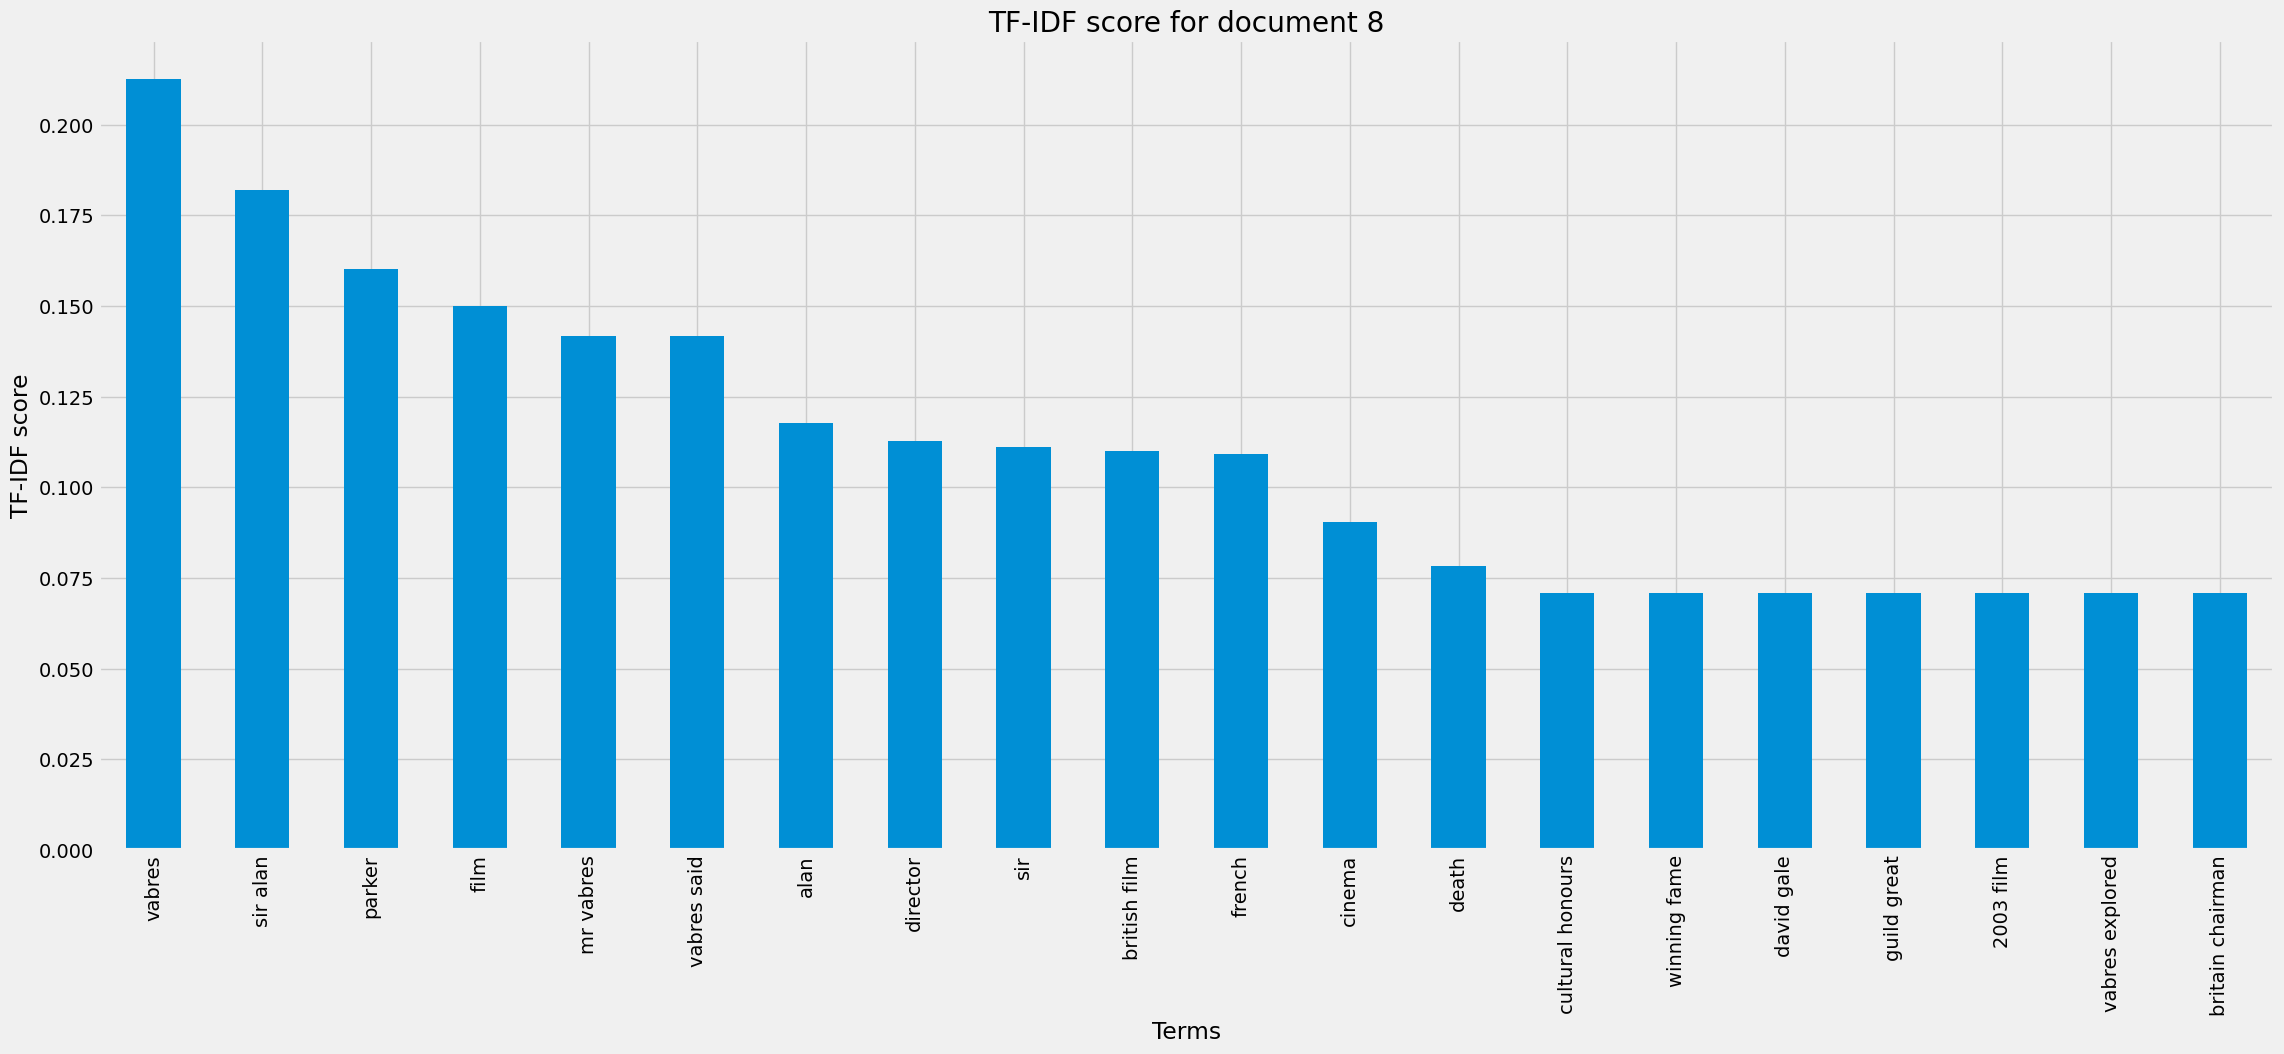

In [25]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

sorted_doc_eight_scores[:20].plot(kind = 'bar')
plt.title('TF-IDF score for document 8')
plt.ylabel('TF-IDF score')
plt.xlabel('Terms')

## Unsupervised Learning

In [26]:
# Non-negative Matrix Factorization (NMF)

# TODO: explain NMF

In [27]:
model_nmf = NMF(n_components = 5, init = 'nndsvd', beta_loss = 'frobenius', max_iter = 200, random_state = 42).fit(df_tfidf)

In [28]:
weights = model_nmf.transform(df_tfidf)
# h = model_nmf.components_

In [29]:
pd.DataFrame(weights).head()

,0,1,2,3,4
0,0.002271,0.027086,0.000000,0.000506,0.071024
1,0.000000,0.000000,0.000000,0.000000,0.156355
2,0.014417,0.013564,0.012873,0.001237,0.101718
3,0.162836,0.000000,0.000000,0.000000,0.000000
4,0.003442,0.001003,0.005479,0.003799,0.070583


In [30]:
pred = np.argmax(weights, axis = 1)

In [31]:
pred

array([4, 4, 4, ..., 4, 0, 0])

In [32]:
def label_compare(y, yp):
    global best_ordering
    unique_labels = np.unique(yp)
    best_accuracy = 0.0

    for order in permutations(unique_labels):
        label_map = {unique_labels[i]: order[i] for i in range(len(unique_labels))}
        reordered_yp = np.vectorize(label_map.get)(yp)
    
        current_score = accuracy_score(y, reordered_yp)
        if current_score > best_accuracy:
            best_accuracy = current_score
            best_ordering = order
    
    return best_accuracy

In [33]:
print(f'The best accuracy achieved with random hyperparameters for the NMF model is: {label_compare(y, pred)}')

The best accuracy achieved with random hyperparameters for the NMF model is: 0.90625


In [34]:
labels = np.unique(pred)
label_map = dict(zip(labels, best_ordering))
reorder_yp = np.array([label_map[lbl] for lbl in pred])

In [35]:
label_names = df_train['Category'].unique().tolist()
l = pd.Index(label_names)
cm = pd.crosstab(l[y], l[reorder_yp])

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'business'),
  Text(0, 1.5, 'entertainment'),
  Text(0, 2.5, 'politics'),
  Text(0, 3.5, 'sport'),
  Text(0, 4.5, 'tech')])

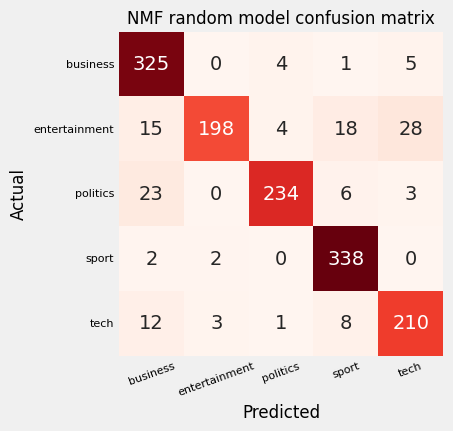

In [36]:
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, square=True, cmap='Reds', fmt='.0f', cbar=False)
plt.title('NMF random model confusion matrix', fontsize = 12)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=20, fontsize=8)
plt.yticks(fontsize=8)

## Hyperparam tuning

In [37]:
def custom_scoring(estimator, X, y):
    W = estimator.transform(X)
    predictions = np.argmax(W, axis=1)
    return label_compare(y, predictions)

In [38]:
pipe = Pipeline([
    ('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
    ('nmf', NMF(n_components = 5, beta_loss='kullback-leibler', solver = 'mu', init = 'nndsvda'))
])

params = [{
    'tfidfvectorizer__ngram_range': [(1, 2)],
    'tfidfvectorizer__min_df': [1, 2, 3],
    'nmf__alpha_W': [0, .01, .02],
    'nmf__alpha_H': [0, .01, .02]
}]

In [39]:
grid = GridSearchCV(pipe, param_grid = params, scoring = custom_scoring, cv = 10)
x = df_train['Text']
y = df_train['category_num']
grid.fit(x, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('nmf',
                                        NMF(beta_loss='kullback-leibler',
                                            init='nndsvda', n_components=5,
                                            solver='mu'))]),
             param_grid=[{'nmf__alpha_H': [0, 0.01, 0.02],
                          'nmf__alpha_W': [0, 0.01, 0.02],
                          'tfidfvectorizer__min_df': [1, 2, 3],
                          'tfidfvectorizer__ngram_range': [(1, 2)]}],
             scoring=<function custom_scoring at 0x3005f1260>)

In [40]:
cv_results = pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_score')

In [46]:
pd.set_option('display.max_colwidth', None)
cv_results[['mean_fit_time', 'params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').iloc[:10]

,mean_fit_time,params,mean_test_score,rank_test_score
11,1.819217,"{'nmf__alpha_H': 0.01, 'nmf__alpha_W': 0, 'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 2)}",0.965278,1
20,1.920746,"{'nmf__alpha_H': 0.02, 'nmf__alpha_W': 0, 'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 2)}",0.965278,1
17,1.907612,"{'nmf__alpha_H': 0.01, 'nmf__alpha_W': 0.02, 'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 2)}",0.965278,1
23,2.004449,"{'nmf__alpha_H': 0.02, 'nmf__alpha_W': 0.01, 'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 2)}",0.965278,1
14,2.198838,"{'nmf__alpha_H': 0.01, 'nmf__alpha_W': 0.01, 'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 2)}",0.965278,5
26,1.956766,"{'nmf__alpha_H': 0.02, 'nmf__alpha_W': 0.02, 'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 2)}",0.964583,6
10,2.456907,"{'nmf__alpha_H': 0.01, 'nmf__alpha_W': 0, 'tfidfvectorizer__min_df': 2, 'tfidfvectorizer__ngram_range': (1, 2)}",0.963889,7
2,1.843097,"{'nmf__alpha_H': 0, 'nmf__alpha_W': 0, 'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 2)}",0.963194,8
25,2.507788,"{'nmf__alpha_H': 0.02, 'nmf__alpha_W': 0.02, 'tfidfvectorizer__min_df': 2, 'tfidfvectorizer__ngram_range': (1, 2)}",0.963194,8
1,2.363049,"{'nmf__alpha_H': 0, 'nmf__alpha_W': 0, 'tfidfvectorizer__min_df': 2, 'tfidfvectorizer__ngram_range': (1, 2)}",0.963194,10


## Best NMF model

In [50]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df = 3, stop_words='english')
features = tfidf.fit_transform(df_train_text)
opt_nmf = NMF(n_components = 5, alpha_H = 0.01, alpha_W = 0, beta_loss='kullback-leibler', solver='mu', init='nndsvda', random_state = 42)
weights = opt_nmf.fit_transform(features)
pred = np.argmax(weights, axis = 1)
print(f'The NMF accuracy with optimal hyperparameters is: {label_compare(y, pred)}')

The NMF accuracy with optimal hyperparameters is: 0.9555555555555556


In [51]:
label_map = dict(zip(labels, best_ordering))
reorder_yp = np.array([label_map[lbl] for lbl in pred])
cm = pd.crosstab(l[y], l[reorder_yp])

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'business'),
  Text(0, 1.5, 'entertainment'),
  Text(0, 2.5, 'politics'),
  Text(0, 3.5, 'sport'),
  Text(0, 4.5, 'tech')])

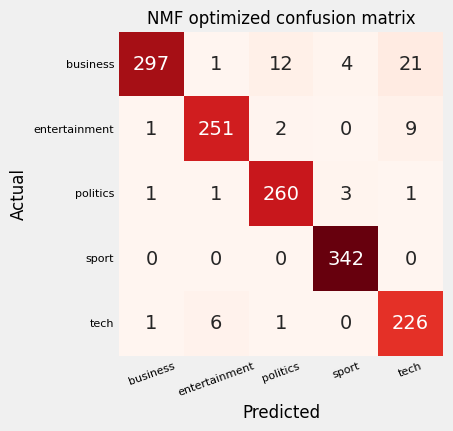

In [53]:
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, square=True, cmap='Reds', fmt='.0f', cbar=False)
plt.title('NMF optimized confusion matrix', fontsize = 12)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=20, fontsize=8)
plt.yticks(fontsize=8)

## References